# Sensitivity analysis

In this notebook we try to study the sensivity of our model to critical parameters.

In [1]:
%run little_awk_functions.py

In [2]:
def squarred_diff(ds, x_sel, y_sel, dt, nb_iterations, total_snow_depth):
    '''
    Function that computes the sum of squarred differences between points on the lidar curve and corresponding
    simulation points
    Args:
        ds: clean dataset
        x_sel: x-coordinate of the point of interest (index)
        y_sel: y-coordinate of the point of interest (index)
        dt: timestep of simulation (s)
        nb_iterations: number of iterations in the simulation
        total_snow_depth: array containing the simulated total snow depth (1 point per iteration)
    Returns:
        sq_sum: sum of the squarred differences between points in ds and points in total_snow_depth
    '''
    sq_sum = 0
    for index in range(len(ds.time.values)):
        lidar_time_in_s = float(ds.time.values[index]) / 1000000000 - float(ds.time.values[0]) / 1000000000
        if lidar_time_in_s < nb_iterations*dt:
            index_of_closest_time_in_simul = int(lidar_time_in_s//dt + round((lidar_time_in_s%dt)/dt))
            difference_curve_lidar = ds.snow_surface.isel(x=x_sel, y=y_sel, time=index) - total_snow_depth[index_of_closest_time_in_simul]
            sq_sum += float(difference_curve_lidar**2)
        else:
            return(sq_sum)
    return(sq_sum)

## Define default parameters

In [3]:
paramdic = {}

In [4]:
# Dataset

name_of_data_set = 'snow_pit_1.nc'

data_set_used = xr.open_dataset(name_of_data_set)
paramdic['data_set_used'] = name_of_data_set

In [5]:
# Events detection parameters

x_sel = 10
y_sel = 10
time_window_std = 25
std_threshold = 0.015

paramdic['x_sel'] = x_sel
paramdic['y_sel'] = y_sel
paramdic['time_window_std'] = time_window_std
paramdic['std_threshold'] = std_threshold

In [15]:
# Compaction/temperature model parameters

tsfc = -25
cp_snow = 2.1
dt = 100
a1 = 0.0013
a2 = 0.021

use_true_temp = True   # set to True if want to use the correct temperature forcing

simul_new_snow_ro = 150
simul_new_snow_temp = -5

paramdic['tsfc'] = tsfc
paramdic['cp_snow'] = cp_snow
paramdic['dt'] = dt
paramdic['a1'] = a1
paramdic['a2'] = a2
paramdic['use_true_temp'] = use_true_temp
paramdic['simul_new_snow_ro'] = simul_new_snow_ro
paramdic['simul_new_snow_temp'] = simul_new_snow_temp

# Will not be varied for now

max_nb_of_layers = 25
simul_fit_top_of_snowfall_to_curve = False
tf = 0
ro_water = 1000
ro_ice = 910
jj = 0

In [7]:
# Save default parameters in a .txt file

with open('sensitivity_tests.txt', 'a') as param_file:
    param_file.write(str(paramdic) + '\n \n')

## Clean dataset and derive other parameters

In [8]:
# Pre-processing to get clean data

if name_of_data_set == 'data_2021-2022.nc':
    fill_in_missing_variables(data_set_used, 'surface')

data_set_used = data_set_used.ffill(dim='time')

median_space_filtering(data_set_used, 5, x_span=7)
if name_of_data_set == 'data_2021-2022.nc':
    median_time_filtering(data_set_used, 11)

data_set_used['snow_surface'] = data_set_used['snow_surface'] - data_set_used['snow_surface'].min() - 0.35414986 #- data_set_used.snow_surface.isel(x=x_sel, y=y_sel, time= start_accumulation[0])
# TODO modular above: will be super important to compute result > use another method instead?
# TODO in any case, add to paramdic


---> Median filtering in space with a window [7, 11]


In [13]:
# Define dates

data_starting_date_in_ns = float(data_set_used.time.values[0])

data_starting_date_in_s = pd.to_datetime(data_set_used.time.values[0]).timestamp()
data_ending_date_in_s = pd.to_datetime(data_set_used.time.values[-1]).timestamp()
data_duration_in_s = data_ending_date_in_s - data_starting_date_in_s
nb_iterations = int(data_duration_in_s/dt + 1)

data_start_date = pd.to_datetime('2021-12-06T00:00')

In [17]:
# Define structures to store snow parameters

ro_layer = np.zeros((max_nb_of_layers, 1))
t_old = np.zeros((max_nb_of_layers, 1))
dy_snow = np.zeros((max_nb_of_layers, 1))
gamma = np.zeros((max_nb_of_layers, 1))
melt_flag = np.zeros((max_nb_of_layers, 1))

In [11]:
# Meteorological forcing

if use_true_temp:
    met_time, met_temp = get_met_forcing()

## Loop on parameter of interest variation

In [20]:
# Define all the values the parameter of interest will take

name_of_param = 'simul_new_snow_ro'
range_of_param_variation = [100, 120, 140, 150, 175, 200, 225, 250]
result_list = []

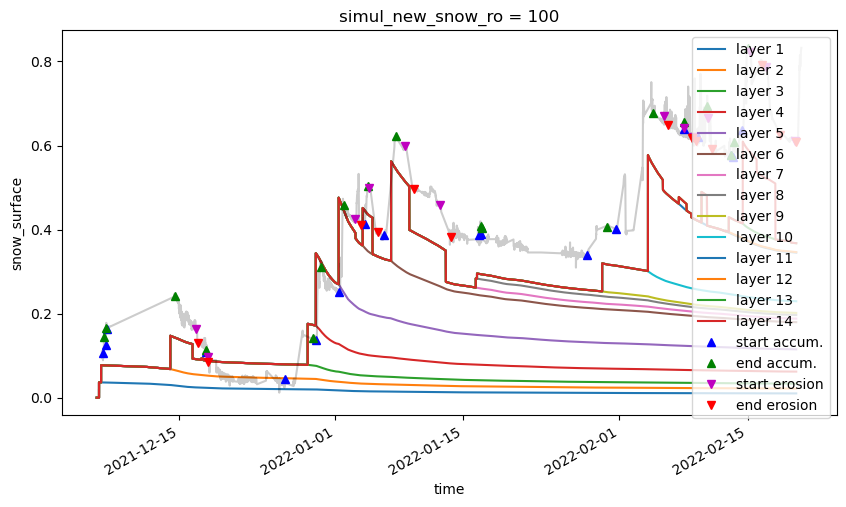

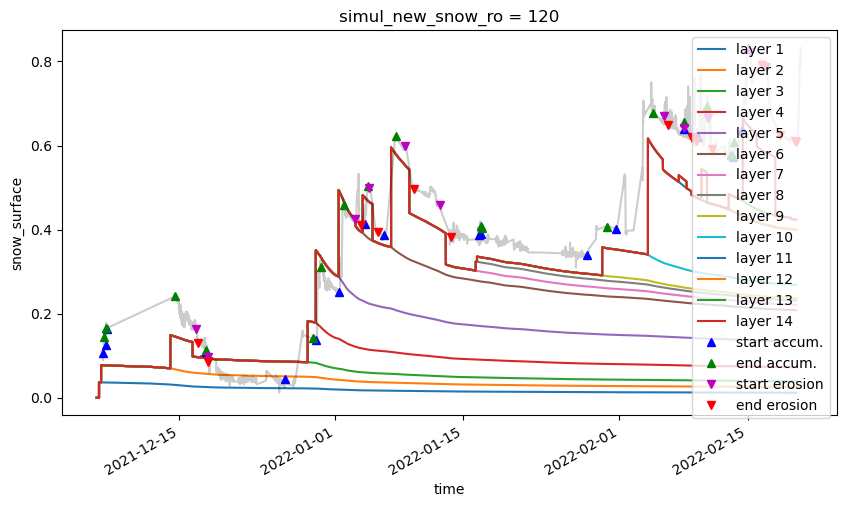

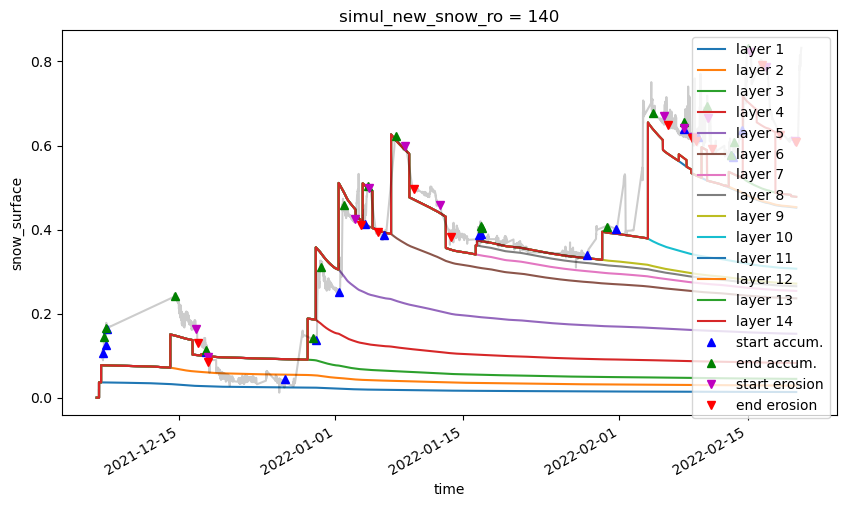

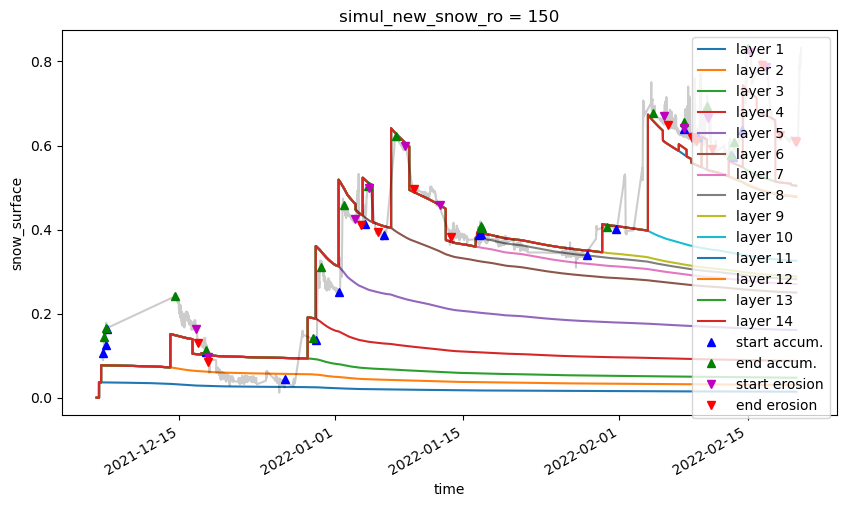

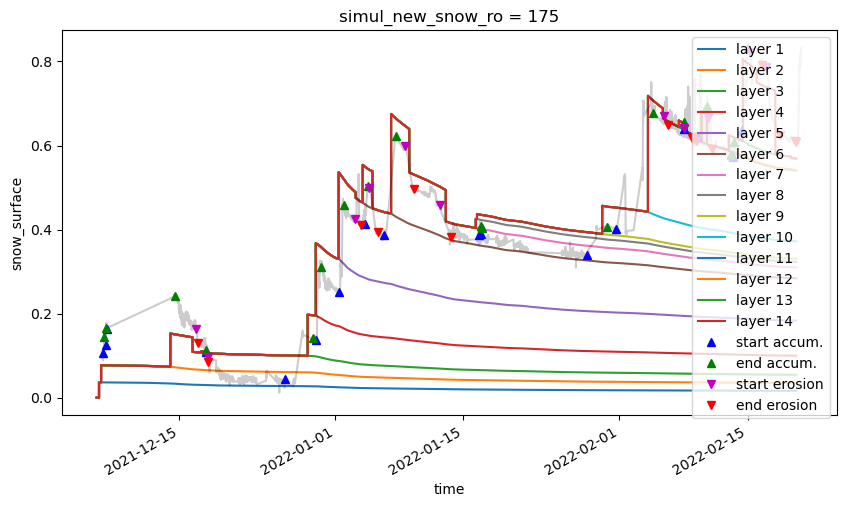

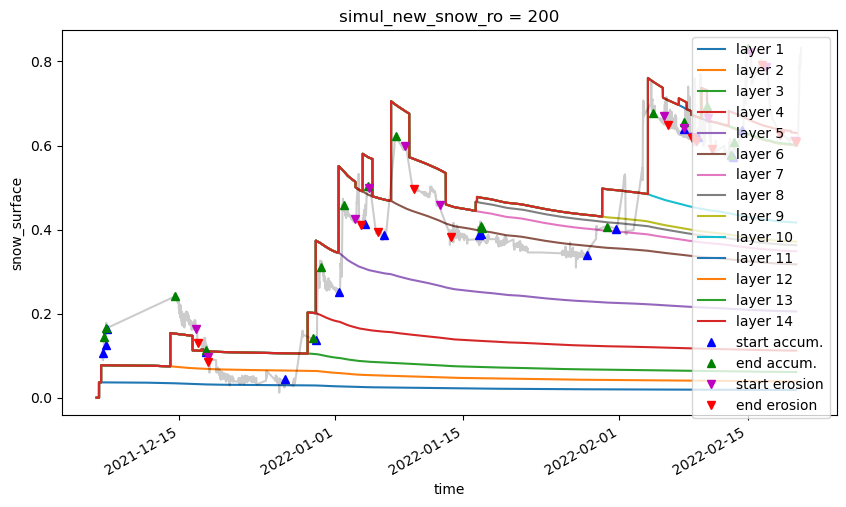

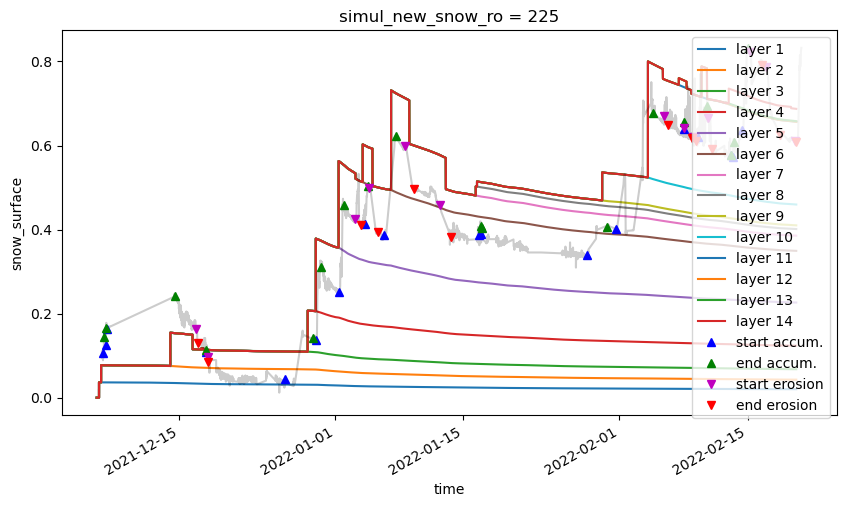

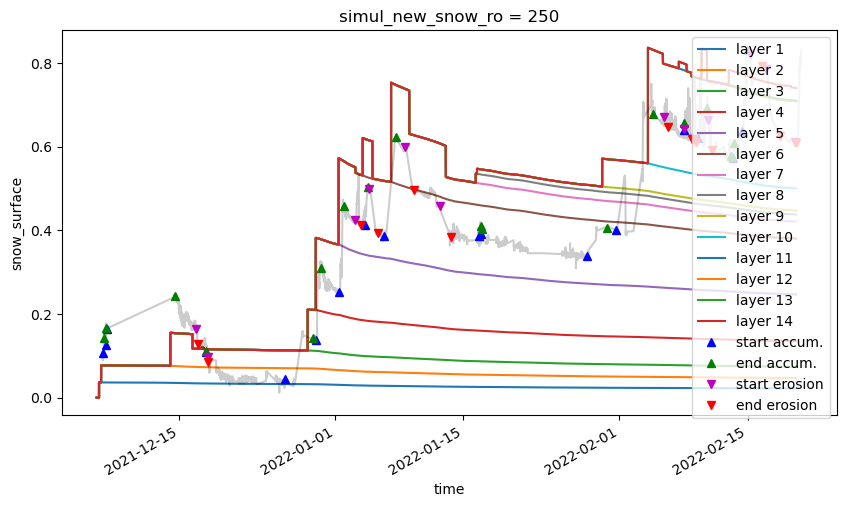

In [21]:
for param in range_of_param_variation:
    
    simul_new_snow_ro = param   # TODO update this each time
    
    results = get_snow_events(data_set_used, x_sel, y_sel, time_window_std, std_threshold)
    start_accumulation = results[0]
    start_erosion = results[1]
    end_accumulation = results[2]
    end_erosion = results[3]

    # Convert end times into more manageable orders of magnitude

    end_accumulation_times = data_set_used.snow_surface.isel(x=x_sel, y=y_sel, time=end_accumulation)
    end_accumulation_times = (pd.to_datetime(end_accumulation_times.time).astype(int) - data_starting_date_in_ns) / 1000000000  # in s

    end_erosion_times = data_set_used.snow_surface.isel(x=x_sel, y=y_sel, time=end_erosion)
    end_erosion_times = (pd.to_datetime(end_erosion_times.time).astype(int) - data_starting_date_in_ns) / 1000000000  # in s

    # Update variables at each timepoint

    snowpack = simulate_snowpack_evolution(data_set_used, x_sel, y_sel, nb_iterations, end_accumulation_times, end_erosion_times,
                                       start_accumulation, end_accumulation, start_erosion, end_erosion, jj, dt, ro_layer, ro_water, ro_ice,
                                       t_old, tf, tsfc, dy_snow, gamma, cp_snow, melt_flag, a1, a2, met_temp_data=met_temp,
                                       met_time_data=met_time, new_snow_ro=simul_new_snow_ro, new_snow_temp=simul_new_snow_temp,
                                       fit_top_of_snowfall_to_curve=simul_fit_top_of_snowfall_to_curve)

    ro_layer_evolution, depth_evolution, temperature_evolution = snowpack[0], snowpack[1], snowpack[2]
    
    # Plot results to compare
    plot_simul_and_signal(data_set_used, x_sel, y_sel, depth_evolution, 14, data_start_date, dt, nb_iterations,
                      start_accumulation, end_accumulation, start_erosion, end_erosion, my_figsize=(10,5),
                      save_file=False, my_title=name_of_param+' = '+str(param))
    # TODO faire plutot un affichage en matrice ?
    # TODO refaire un affichage avec une fonction qui recupere only the top layer (sum of all layer heights)
    # TODO plot ensemble la courbe reference et les autres courbes
 
    # Define total_snow_depth
    total_snow_depth = [sum(depth_evolution[i][j] for j in range(max_nb_of_layers)) for i in range(len(depth_evolution))]
    
    result_eval = squarred_diff(data_set_used, x_sel, y_sel, dt, nb_iterations, total_snow_depth)
    
    result_list.append(result_eval)

In [44]:
# Save parameters and results in a .txt file

with open('sensitivity_tests.txt', 'a') as param_file:
    param_file.write(name_of_param + str(range_of_param_variation) + str(result_list) + '\n \n')

## Plot results in terms of squarred difference to the lidar curve

In [22]:
# TODO optimize each time as a function of offset added to lidar curve?

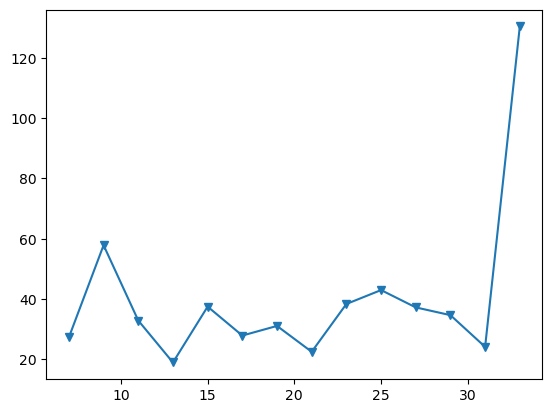

In [46]:
plt.plot(range_of_param_variation, result_list, marker='v')